In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Input, AveragePooling1D, Dropout
from keras.optimizers import Adam, Nadam
from keras.regularizers import L2
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

from time import perf_counter

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
tf.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4664842878024038181
xla_global_id: -1
]


'2.16.1'

In [3]:
stresses = ['Gm', 'Drought', 'Nutrient_Deficiency', 'Fs', 'Salinity']

In [4]:
csv_path = r'..\combined.csv'
df = pd.read_csv(csv_path)
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df.drop(columns=['Fungal_infection'], inplace=True, errors='ignore')
df[stresses] = df[stresses].astype(bool)

C:\Users\amitt\AppData\Local\Temp\ipykernel_8568\1297277926.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [5]:
spec_cols = [col for col in df.columns if col[0] == 'X']

In [6]:
df['Stressed'] = df[stresses].any(axis=1)

In [7]:
def drop_res(x, blur_factor=10):
    spec_x = x[:,:(x.shape[1]//blur_factor * blur_factor)]
    blur_x = (spec_x.flatten()
     .reshape((spec_x.shape[0] * spec_x.shape[1] // blur_factor, blur_factor))
     .mean(axis=1)
     .reshape((spec_x.shape[0], spec_x.shape[1] // blur_factor))
    )

    return blur_x

In [8]:
fuzzy_win = 5
# fuzzy_dx_kernel = np.hstack((np.ones(fuzzy_win) * -1/fuzzy_win, np.ones(fuzzy_win)/fuzzy_win))

# def fuzzy_dx(arr):
#     return np.apply_along_axis(lambda x: np.convolve(x, fuzzy_dx_kernel, mode='valid'), arr=arr, axis=1)

# fuzzy_dx3 = fuzzy_dx(fuzzy_dx(fuzzy_dx(df[spec_cols].values)))

In [9]:
def cnn_reshape(x):
    return x.reshape((-1, x.shape[1], 1))

In [10]:
blur_factor = 5

# x = drop_res(fuzzy_dx3, blur_factor=blur_factor)
x = df[spec_cols].values
y = df['Stressed']

x /= x.max()

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2)

In [56]:
def fuzzy_dx_init(shape, dtype=None):
    half_shape = list(shape)
    half_shape[0] //= 2
    half_shape = tuple(half_shape)
    return np.vstack((np.ones(half_shape) * -1/half_shape[0], np.ones(half_shape)/half_shape[0]))

model = Sequential([
    Input(shape=(x_train.shape[1],1)),
    Conv1D(1, fuzzy_win*2, trainable=False, kernel_initializer=fuzzy_dx_init),
    Conv1D(1, fuzzy_win*2, trainable=False, kernel_initializer=fuzzy_dx_init),
    Conv1D(1, fuzzy_win*2, trainable=False, kernel_initializer=fuzzy_dx_init),
    AveragePooling1D(blur_factor),
    Conv1D(20, 10, kernel_regularizer=L2(.001)),
    MaxPooling1D(2),
    Flatten(),
    Dense(20, kernel_regularizer=L2(.001)),
    Dense(20, kernel_regularizer=L2(.001)),
    Dense(1)
])

model.compile(optimizer=Nadam(1e-4, beta_1=.75, beta_2=.9), loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
start = perf_counter()

history = model.fit(
    cnn_reshape(x_train),
    y_train,
    epochs=200,
    validation_data=(cnn_reshape(x_val), y_val),
    batch_size=50,
)

print(perf_counter() - start)

Epoch 1/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5086 - loss: 1.3231 - val_accuracy: 0.6080 - val_loss: 0.7187
Epoch 2/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6176 - loss: 0.7115 - val_accuracy: 0.6080 - val_loss: 0.7099
Epoch 3/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6179 - loss: 0.7012 - val_accuracy: 0.6080 - val_loss: 0.7008
Epoch 4/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6199 - loss: 0.6928 - val_accuracy: 0.6080 - val_loss: 0.6916
Epoch 5/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6167 - loss: 0.6884 - val_accuracy: 0.6219 - val_loss: 0.6934
Epoch 6/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6157 - loss: 0.6832 - val_accuracy: 0.6080 - val_loss: 0.6817
Epoch 7/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6222 - loss: 0.6761 - val_accuracy: 0.6080 - val_loss: 0.6772
Epoch 8/200
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6242 - loss: 0.6721 - val_accu

Text(0.5, 1.0, 'CNN Accuracy over Training')

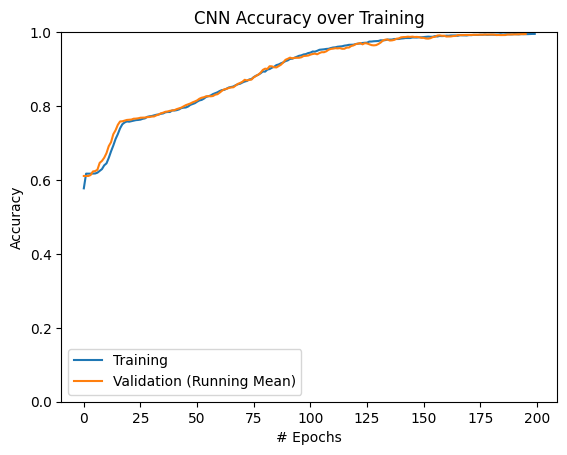

In [58]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['accuracy'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_accuracy']), np.ones(5)/5, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim((0, 1))
ax.set_title('CNN Accuracy over Training')